# RNN

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

from bs4 import BeautifulSoup
import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt


# 데이터 불러오기


In [2]:
import FinanceDataReader as fdr
emro_stock = fdr.DataReader('058970', start = '2018-01-01', end = '2023-04-05')

In [3]:
display(emro_stock)
display(emro_stock.info())

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2018-01-02,2985,2985,2360,2650,25478,-0.018519
2018-01-03,2700,2890,2700,2800,8374,0.056604
2018-01-04,2800,2800,2795,2795,1948,-0.001786
2018-01-05,2795,2800,2795,2800,1321,0.001789
2018-01-08,2705,2795,2705,2795,425,-0.001786
...,...,...,...,...,...,...
2023-03-30,54500,59400,53200,54700,577812,-0.023214
2023-03-31,53600,57000,51500,55300,435436,0.010969
2023-04-03,55200,56400,53000,53600,298290,-0.030741


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1297 entries, 2018-01-02 to 2023-04-05
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1297 non-null   int64  
 1   High    1297 non-null   int64  
 2   Low     1297 non-null   int64  
 3   Close   1297 non-null   int64  
 4   Volume  1297 non-null   int64  
 5   Change  1297 non-null   float64
dtypes: float64(1), int64(5)
memory usage: 70.9 KB


None

In [4]:
# 결측치 처리
emro_stock = emro_stock.interpolate()
scaler = MinMaxScaler()

df = emro_stock.copy()
df[['Open', 'High', 'Low', 'Close', 'Volumne']] = scaler.fit_transform(df[['Open', 'High', 'Low', 'Close', 'Volume']])

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1297 entries, 2018-01-02 to 2023-04-05
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Open     1297 non-null   float64
 1   High     1297 non-null   float64
 2   Low      1297 non-null   float64
 3   Close    1297 non-null   float64
 4   Volume   1297 non-null   int64  
 5   Change   1297 non-null   float64
 6   Volumne  1297 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 81.1 KB


### 텐서 데이터 만들기

In [6]:
# CPU / GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'{device} is available')

cuda:0 is available


In [7]:
# Dataset
X = df[['Open', 'High', 'Low', 'Volume']].values
y = df['Close'].values


In [8]:
def seq_data(x, y, sequence_length):

    x_seq = []
    y_seq = []
    for i in range(len(x) - sequence_length):
        x_seq.append(x[i:i+sequence_length]) # a[2:6] -> 2, 3, 4, 5
        y_seq.append(y[i+sequence_length]) # 그 다음날꺼 하나 예측

    return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(device).view([-1, 1])



split = 200 # 200까지는 train, 그 이후는 test
sequence_length = 5

x_seq, y_seq = seq_data(X, y, sequence_length) 
x_train_seq = x_seq[:split]
y_train_seq = y_seq[:split]

x_test_seq = x_seq[split:]
y_test_seq = y_seq[split:]

print(x_train_seq.size(), y_train_seq.size())
print(x_test_seq.size(), y_test_seq.size())
    
# 맨앞 size는 row 개수
# size에서 중간에 5는 sequence length 길이, 5일치
# size에서 맨마지막 4는 컬럼 개수 


torch.Size([200, 5, 4]) torch.Size([200, 1])
torch.Size([1092, 5, 4]) torch.Size([1092, 1])


C:\Users\user\AppData\Local\Temp\ipykernel_7296\2064190101.py:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:248.)
  return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(device).view([-1, 1])


In [9]:
'''
 PyTorch의 TensorDataset은 tensor를 감싸는 Dataset입니다.

 인덱싱 방식과 길이를 정의함으로써 이것은 tensor의 첫 번째 차원을 따라 반복, 인덱스, 슬라이스를 위한 방법을 제공합니다.

 훈련할 때 동일한 라인에서 독립 변수와 종속 변수에 쉽게 접근할 수 있습니다.
'''

train = torch.utils.data.TensorDataset(x_train_seq, y_train_seq)
test = torch.utils.data.TensorDataset(x_test_seq, y_test_seq)

batch_size = 32
train_loader = torch.utils.data.DataLoader(dataset = train, batch_size = batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset = test, batch_size = batch_size, shuffle=False)


### Hyperparameter 설정

In [10]:
# RNN
input_size = x_seq.size(2)
num_layers = 2
hidden_size = 8

# layer나 hidden size가 커지면 오버피팅될 가능성이 높다.


In [11]:
class VanillaRNN(nn.Module):

    def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
        super(VanillaRNN, self).__init__()
        self.device = device
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first = True) # 파이토치에서는 RNN을 한줄로 제공한다. 파이토치 RNN은 sequence 길이가 먼저 들어와야한다. 원래 permute로 순서를 바꿔줘야하는데
        # 바꾸기 귀찮으면 batch_first = True로 설정해주면 된다.
        self.fc = nn.Sequential(nn.Linear(hidden_size*sequence_length, 1), nn.Sigmoid()) # fully connected layer에 넣으려면 flatten해야한다.

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device) # 초기 hidden state설정
        out, _ = self.rnn(x, h0) # out: RNN의 마지막 레이어로부터 나온 output feature 반환, hn: hidden state반환
        out = out.reshape(out.shape[0], -1)
        out = self.fc(out)
        return out

In [12]:
model = VanillaRNN(input_size = input_size,
                   hidden_size = hidden_size,
                   sequence_length = sequence_length,
                   num_layers = num_layers,
                   device=device).to(device)

In [13]:
criterion = nn.MSELoss()

lr = 1e-3
num_epochs = 200
optimizer = optim.Adam(model.parameters(), lr= lr)


### 모델 학습하기

In [14]:
loss_graph = []
n = len(train_loader)

for epoch in range(num_epochs):
    running_loss = 0.0

    for data in train_loader:

        seq, target = data # 배치 데이터
        out = model(seq)
        loss = criterion(out, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()


    loss_graph.append(running_loss/n)
    if epoch % 100 ==0:
        print('[epoch: %d] loss: %.4f' %(epoch, running_loss/n))

[epoch: 0] loss: 0.1633
[epoch: 100] loss: 0.0000


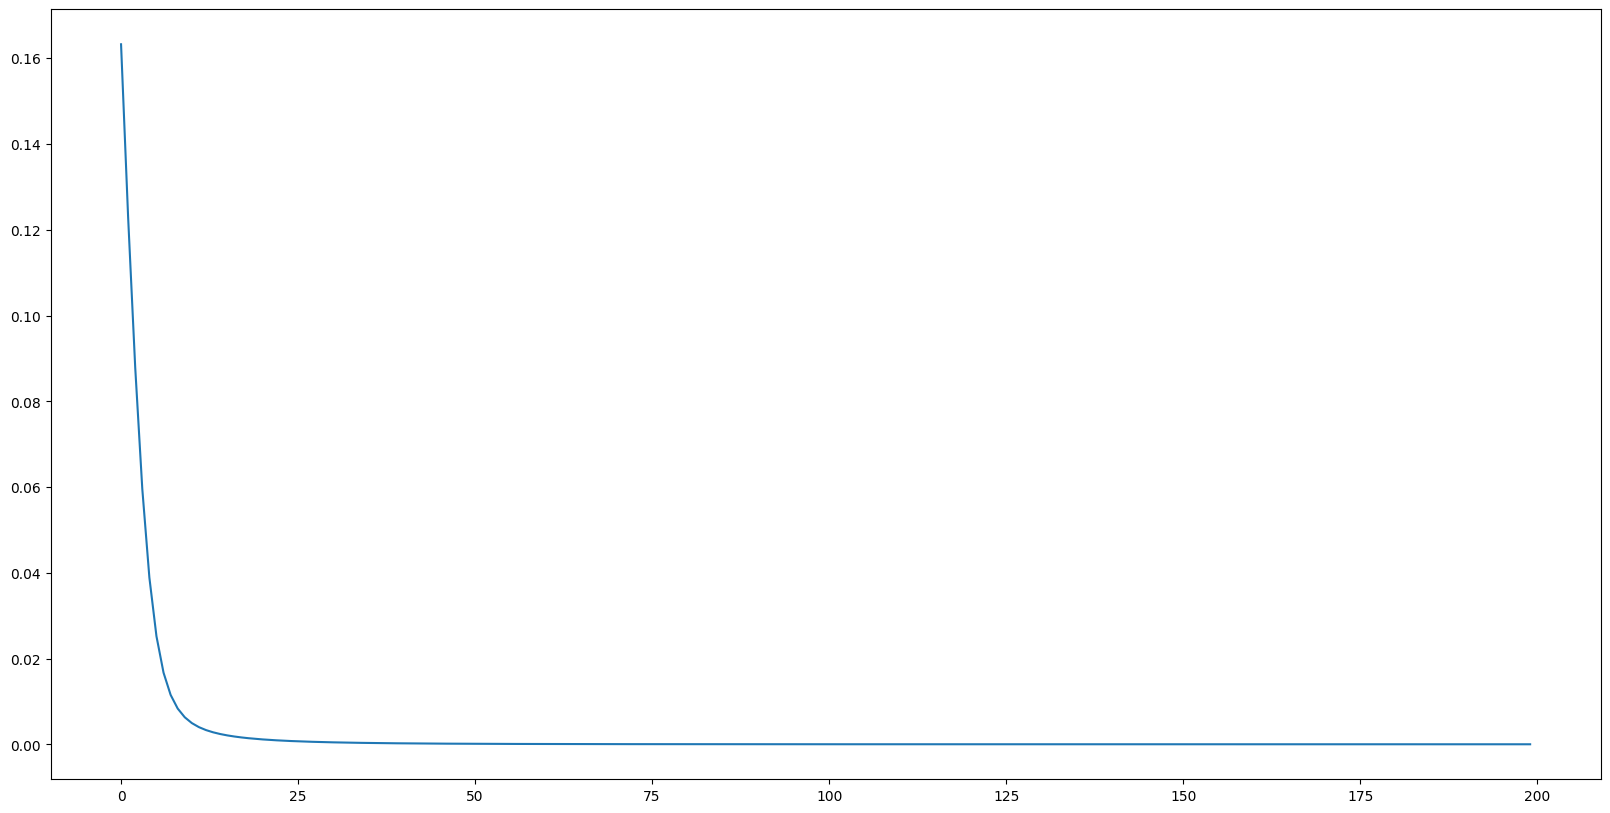

In [15]:
plt.figure(figsize = (20, 10))
plt.plot(loss_graph)
plt.show()

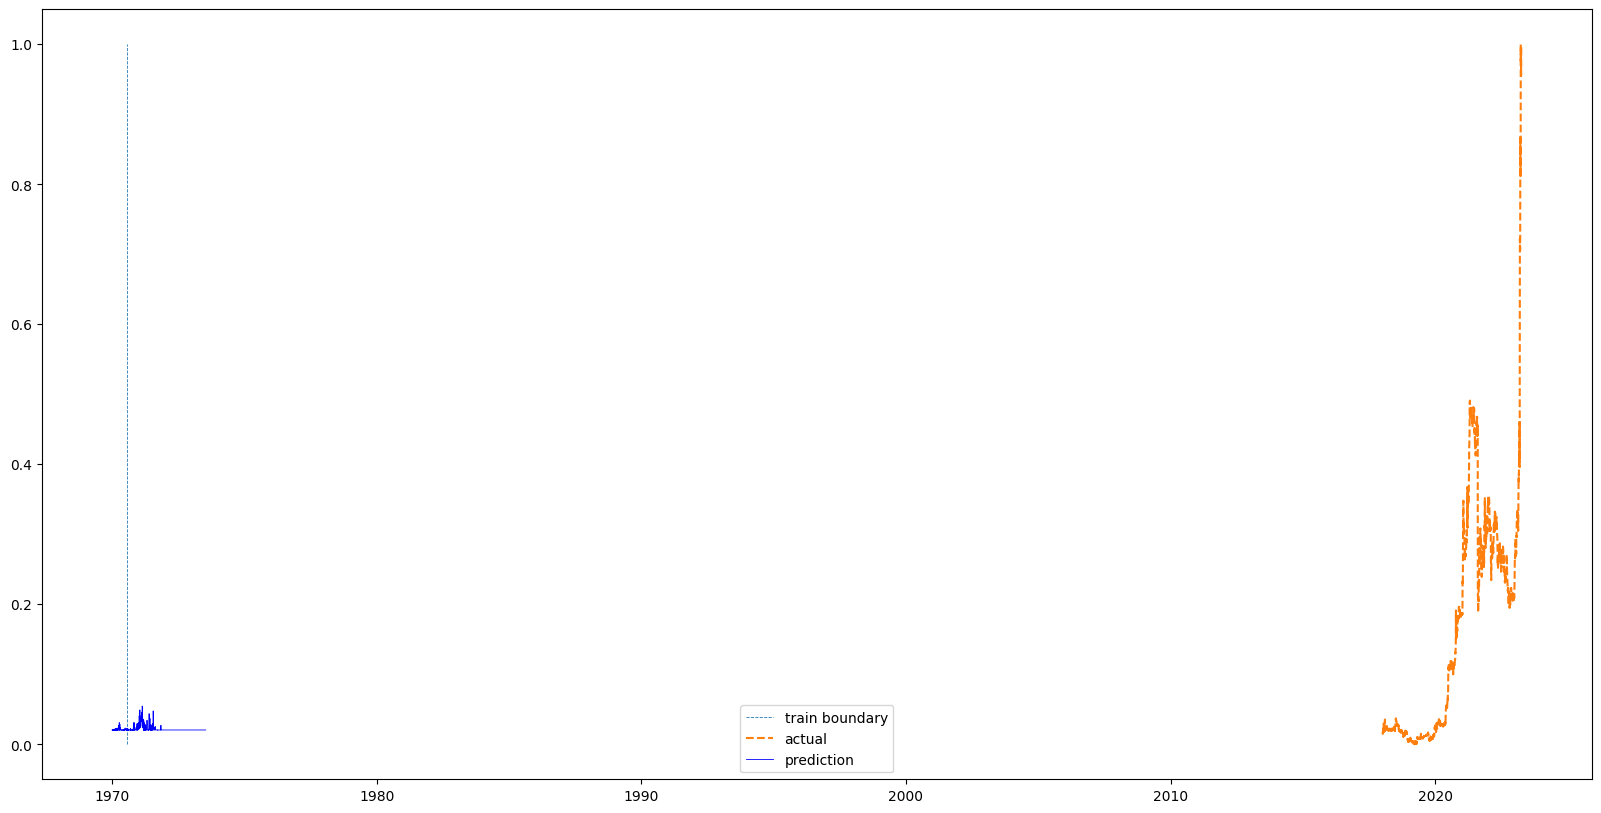

In [16]:
def plotting(train_loader, test_loader, actual):
    with torch.no_grad():
        train_pred = []
        test_pred = []

        for data in train_loader:
            seq, target = data # 배치 데이터
            out = model(seq)
            train_pred += out.cpu().numpy().tolist() # 이거 신기하네

        for data in test_loader:
            seq, target = data # 배치 데이터
            out = model(seq)
            test_pred += out.cpu().numpy().tolist()

    total = train_pred+test_pred # 하나의 리스트안에 쭉 배열, train_pred 다음에 test_pred 값이 온다.
    plt.figure(figsize = (20, 10))
    plt.plot(np.ones(100)*len(train_pred), np.linspace(0, 1, 100), '--', linewidth = 0.6)
    plt.plot(actual, '--')
    plt.plot(total, 'b', linewidth=0.6)


    plt.legend(['train boundary', 'actual', 'prediction'])
    plt.show()

plotting(train_loader, test_loader, df['Close'][sequence_length:])


In [17]:
a= [1,2, 3]
b=[4,5,6]
a+b

[1, 2, 3, 4, 5, 6]